# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

**TODO**:
- quantify run times
- figure out overflow
- make sure quadcopter converges

In [1]:
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents, plot_solve
import decentralized as dec
import pocketknives

π = np.pi

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, \
    decentralized.problem, decentralized.util, decentralized.decentralized

In [3]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = True

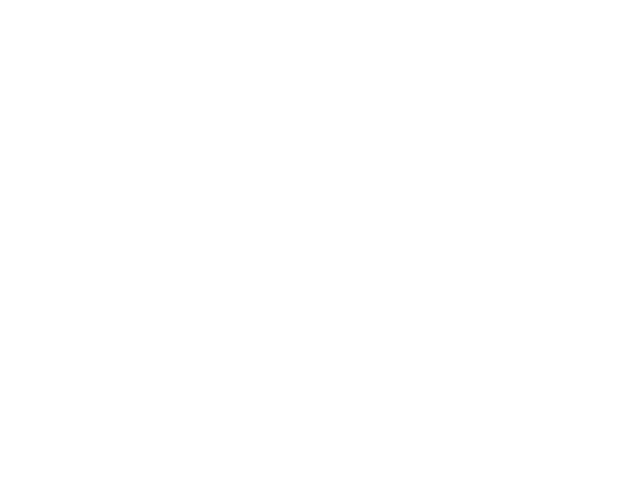

In [37]:
# fig = plt.figure(figsize=(3.7, 3.7))
fig = plt.figure()

## single-agent problem

In [5]:
dt = 0.05
N = 50
n_d = 2

x = np.array([-10, 10, 10, 0], dtype=float)
x_goal = np.zeros((4, 1), dtype=float).T

# dynamics = dec.DoubleIntDynamics4D(dt)
dynamics = dec.UnicycleDynamics4D(dt)

Q = np.diag([1., 1, 0, 0])
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal)
plt.draw()

0/50	J: 432856
1/50	J: 4390.33	μ: 0.5	Δ: 0.5
2/50	J: 4096.25	μ: 0.125	Δ: 0.25
3/50	J: 3473.41	μ: 0.015625	Δ: 0.125
4/50	J: 3428.29	μ: 0.000976562	Δ: 0.0625
5/50	J: 3371.06	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3263.24	μ: 0	Δ: 0.015625
7/50	J: 3236.36	μ: 0	Δ: 0.0078125
8/50	J: 3211.05	μ: 0	Δ: 0.00390625
9/50	J: 3206.25	μ: 0	Δ: 0.00195312
10/50	J: 3198.65	μ: 0	Δ: 0.000976562


Show equations of motion, which have the form

$$\dot{x} = f(x, u, p)$$

for states

$$
x = \begin{bmatrix} o_x & o_y & o_z & \psi & \theta & \phi & v_x & v_y & v_z & w_x & w_y & w_z \end{bmatrix},
$$

inputs
$$
u = \begin{bmatrix} \tau_x & \tau_y & \tau_z & f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m & J_x & J_y & J_z & g \end{bmatrix}.
$$

In [6]:
# Single-agent problem for a quadcopter (w/ analytical diff.)
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 0.5 , 0.05, 0, 0, 0.0, 0.0, 0, 0, 0, 0], dtype=float)
x_goal = np.zeros((12, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics12D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(4)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal, n_d=n_d)
plt.draw()

0/50	J: 828200
1/50	J: 201717	μ: 0.5	Δ: 0.5
2/50	J: 21847	μ: 0.125	Δ: 0.25
3/50	J: 556.517	μ: 0.015625	Δ: 0.125
4/50	J: 231.79	μ: 0.000976562	Δ: 0.0625
5/50	J: 177.952	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 152.816	μ: 0	Δ: 0.015625
7/50	J: 151.208	μ: 0	Δ: 0.0078125
8/50	J: 142.319	μ: 0	Δ: 0.00390625
9/50	J: 139.107	μ: 0	Δ: 0.00195312
10/50	J: 135.074	μ: 0	Δ: 0.000976562
11/50	J: 132.781	μ: 0	Δ: 0.000488281
12/50	J: 131.395	μ: 0	Δ: 0.000244141
13/50	J: 130.306	μ: 0	Δ: 0.00012207
14/50	J: 129.877	μ: 0	Δ: 6.10352e-05
15/50	J: 129.426	μ: 0	Δ: 3.05176e-05


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [7]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = np.array([[0.5, 1.5, 0, 0.1,
                    2.5, 1.5, 0, π,
                    1.5, 1.3, 0, π/2]], 
                     dtype=float).T
    x_goal = np.array([[2.5, 1.5, 0, 0, 
                        0.5, 1.5, 0, π, 
                        1.5, 2.2, 0, π/2]]).T
    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = np.array([[5, 5, 0, 0,
                          6, 6, 0, π/4]]).T
    x_goal_other = np.array([[6, 4, 0, -π/2,
                              4, 6, 0, π/4]]).T
    
    x0 = np.concatenate([x0, x0_other]) 
    x_goal = np.concatenate([x_goal, x_goal_other])    
    
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [40]:
plt.annotate?

Signature: plt.annotate(text, xy, *args, **kwargs)
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default: *xy*
    The position *(x, y)* to place the text at. The coordinate system
    is determined by *textcoords*.

xycoords : str or `.Artist` or `.Transform` or callable or (float, float), default: 'data'

    The coordinate system that *xy* is given in. The following types
    of values are supported:

    - One of the following strings:

      ==================== ============================================
      Value                Description
      ===

In [39]:
n_agents = 3
n_states = 6
n_controls = 3
ENERGY = 10.0
n_d = 2

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = dec.random_setup(
    n_agents, n_states, 
    is_rotation=False, 
    rel_dist=2.0, 
    var=1.0, 
    n_d=n_d, 
    random=False
)

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents

# x0 = dec.normalize_energy(x0, x_dims, ENERGY)
# x_goal = dec.normalize_energy(x_goal, x_dims, ENERGY)
# x0 = dec.perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = np.dstack([
    x0.reshape(n_agents, n_states), 
    x_goal.reshape(n_agents, n_states)
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

In [25]:
dt = 0.1
N = 40
tol = 1e-3
ids = [100 + i for i in range(n_agents)]

# model = dec.DoubleIntDynamics4D
# model = dec.UnicycleDynamics4D
# model = dec.BikeDynamics5D
model = dec.QuadcopterDynamics6D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])

Q = 1.0 * np.diag([1, 1, 0, 0])
# Q = 1.0 * np.diag([1, 1, 1, 1, 1, 1])
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(n_controls)

# radius = ENERGY / 20
radius = 0.5

goal_costs = [dec.ReferenceCost(x_goal_i, Q.copy(), R.copy(), Qf.copy(), id_) 
              for x_goal_i, id_ in zip(split_agents(x_goal.T, x_dims), ids)]
prox_cost = dec.ProximityCost(x_dims, radius)
game_cost = dec.GameCost(goal_costs, prox_cost)

prob = dec.ilqrProblem(dynamics, game_cost)

In [26]:
# %%time
ilqr = dec.ilqrSolver(prob, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol, t_kill=None)

0/50	J: 32271.6
1/50	J: 15537.7	μ: 0.5	Δ: 0.5
2/50	J: 10702.2	μ: 0.125	Δ: 0.25
3/50	J: 6594.33	μ: 0.015625	Δ: 0.125
4/50	J: 1853.65	μ: 0.000976562	Δ: 0.0625
5/50	J: 1663.66	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 1551.45	μ: 0	Δ: 0.015625
7/50	J: 1509.64	μ: 0	Δ: 0.0078125
8/50	J: 1453.01	μ: 0	Δ: 0.00390625
9/50	J: 1405.48	μ: 0	Δ: 0.00195312
10/50	J: 1390.52	μ: 0	Δ: 0.000976562
11/50	J: 1373.88	μ: 0	Δ: 0.000488281
12/50	J: 1372.35	μ: 0	Δ: 0.000244141
13/50	J: 1370.08	μ: 0	Δ: 0.00012207
Failed line search, giving up.


In [33]:
plt.clf()
plot_solve(X, J, x_goal.T, x_dims, n_d)

In [29]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_d).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

In [30]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## decentralized multi-agent

In [31]:
graph = dec.define_inter_graph_threshold(X, radius, x_dims, ids)
graph

{100: [100, 101, 102], 101: [100, 101], 102: [100, 102]}

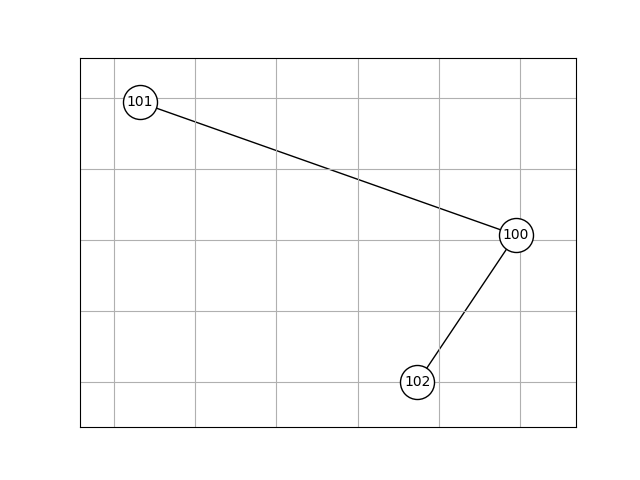

In [34]:
plt.clf()
dec.plot_interaction_graph(graph)

In [92]:
%%time
X0 = np.tile(x0.T, (N,1))
U0 = np.zeros((N, n_controls*n_agents))
X_dec, U_dec, J_dec, solve_times = \
    dec.solve_decentralized(prob, X0, U0, radius, is_mp=False)

Interaction Graph: {100: [100], 101: [101], 102: [102]}
0/50	J: 720381
1/50	J: 26793.8	μ: 0.5	Δ: 0.5
2/50	J: 4627.54	μ: 0.125	Δ: 0.25
3/50	J: 4551.48	μ: 0.015625	Δ: 0.125
4/50	J: 4534.78	μ: 0.000976562	Δ: 0.0625
5/50	J: 4499.9	μ: 3.05176e-05	Δ: 0.03125
Problem 100: [100]
Took 0.33328350000374485 seconds
0/50	J: 977328
1/50	J: 27782.4	μ: 0.5	Δ: 0.5
2/50	J: 5855.03	μ: 0.125	Δ: 0.25
3/50	J: 5788.13	μ: 0.015625	Δ: 0.125
4/50	J: 5671.53	μ: 0.000976562	Δ: 0.0625
5/50	J: 5636.94	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 5630.43	μ: 0	Δ: 0.015625
Problem 101: [101]
Took 0.4707910000142874 seconds
0/50	J: 641855
1/50	J: 4673.41	μ: 0.5	Δ: 0.5
2/50	J: 4619.24	μ: 0.125	Δ: 0.25
Problem 102: [102]
Took 0.10149139999703038 seconds
CPU times: total: 922 ms
Wall time: 923 ms


In [15]:
plt.clf()
plot_solve(X_dec, J_dec, x_goal, x_dims, n_d)

NameError: name 'X_dec' is not defined

In [94]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X_dec, x_dims, n_d).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

## receding horizon

In [16]:
%%time
step_size = 1
U0 = np.zeros((N, dynamics.n_u))
X, U, J = dec.solve_rhc(
    prob, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=N*dt
)

t: 0
Interaction Graph: {100: [100], 101: [101], 102: [102]}
0/50	J: 703730
1/50	J: 4067.91	μ: 0.5	Δ: 0.5
Killing due to exceeded computation time 0.0651 > 0.05 s.
Problem 100: [100]
Took 0.07676440000068396 seconds
0/50	J: 988627
1/50	J: 50569.9	μ: 0.5	Δ: 0.5
Killing due to exceeded computation time 0.0873 > 0.05 s.
Problem 101: [101]
Took 0.09694110001146328 seconds
0/50	J: 687164
1/50	J: 4248.08	μ: 0.5	Δ: 0.5
Killing due to exceeded computation time 0.0574 > 0.05 s.
Problem 102: [102]
Took 0.07465939999383409 seconds
t: 0.05
Interaction Graph: {100: [100], 101: [101, 102], 102: [101, 102]}
0/50	J: 4448.82
1/50	J: 4063.94	μ: 0.5	Δ: 0.5
Problem 100: [100]
Took 0.06603230000473559 seconds
0/50	J: 11026.5
Killing due to exceeded computation time 0.106 > 0.05 s.
Problem 101: [101, 102]
Took 0.1246233999991091 seconds
0/50	J: 11026.5
Killing due to exceeded computation time 0.104 > 0.05 s.
Problem 102: [101, 102]
Took 0.11863250000169501 seconds
t: 0.1
Interaction Graph: {100: [100], 101:

In [18]:
plt.clf()
plot_solve(X, J, x_goal, x_dims, n_d)

## animation

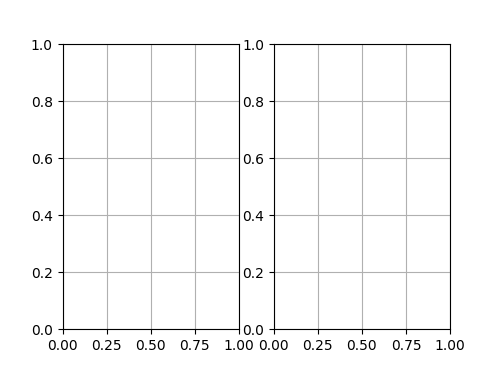

In [17]:
_, axes = plt.subplots(1, 2, figsize=(5.0, 3.7))

In [ ]:
def setup(axes, X, x_goal, x_dims, radius):
    
    ax1, ax2 = axes
    n_agents = len(x_dims)
    handles1 = []
    for i in range(n_agents):
        handles1.append((
            ax1.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax1.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2)),
        ))
        
    for xg in split_agents(x_goal, x_dims):
        ax1.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, axes[0], zoom=0.15)
    plt.draw()
    
    handles2 = []
    n_pairs = pocketknives.nchoosek(n_agents, 2)
    for i in range(n_pairs):
        handles2.append(ax2.plot(0, c=plt.cm.tab20.colors[2*i])[0])
    ax2.hlines(radius, 0, X.shape[0], 'r', ls='--')
    ax2.set_ylim(0.0, distances.max())
        
    return handles1, handles2
    
def animate(t, handles1, handles2, X, x_dims, x_goal, distances):
    """Animate the solution into a gif"""
    
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles1):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
        
    for i, hi in enumerate(handles2):
        hi.set_xdata(range(t))
        hi.set_ydata(distances[:t, i])
    
    plt.draw()
    

In [ ]:
distances = dec.compute_pairwise_distance(X, x_dims).T
handles1, handles2 = setup(axes, X, x_goal.flatten(), x_dims, radius)
animate(10, handles1, handles2, X, x_dims, x_goal, distances)
plt.draw()

In [ ]:
handles = setup(axes, X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(
    plt.gcf(), 
    animate, 
    frames=N+1, 
    fargs=(*handles, X, x_dims, x_goal, distances))
anim.save('traj.gif', fps=5)

## old

In [ ]:
# Old RHC for plotting...
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=5)
U0 = np.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=101.0, tol=tol, verbose=False):
    plt.cla()
    plot_solve(Xi, Ji, x_goal.T, x_dims)
    fig.canvas.draw()

In [ ]:
# Manual decentralized RHC for plotting...
step_size = 5
Xi = np.tile(x0.T, (N,1))
Ui = np.zeros((N, dynamics.n_u))
X_dec = np.zeros((0, dynamics.n_x))
U_dec = np.zeros((0, dynamics.n_u))
Ji = np.inf
J_converge = 100.0

while Ji >= J_converge:
    Xi, Ui, Ji = dec.solve_decentralized(prob, Xi, Ui, radius, is_mp=False)
    
    X_dec = np.r_[X_dec, Xi[:step_size]]
    U_dec = np.r_[U_dec, Ui[:step_size]]
    
    # Seed the next solve by staying at the last visited state.
    Xi = np.r_[Xi[step_size:], np.tile(Xi[-1], (step_size, 1))]
    Ui = np.r_[Ui[step_size:], np.zeros((step_size, dynamics.n_u))]
    
    plt.cla()
    plot_solve(Xi[:step_size], Ji, x_goal.T, x_dims)
    fig.canvas.draw()